In [327]:
import os
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from scipy.io import loadmat
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis
from sklearn.metrics import log_loss
from sklearn.metrics import confusion_matrix


random_state = 10 # Ensure reproducible results
%matplotlib inline

In [328]:
ing_mat = loadmat('MATLAB/ingredients.mat')['ingredients']
cityDist_mat = loadmat('MATLAB/citiesDistMat.mat')['citiesDistMat']
labelName_mat = loadmat('MATLAB/labelNames.mat')['labelNames']
labelName_mat = [item for sublist in labelName_mat for item in sublist]
labels_mat = loadmat('MATLAB/labels.mat')['labels']
recipe_mat = loadmat('MATLAB/recipes.mat')['recipes']
ing_headline = []
for i in ing_mat[0]:
    ing_headline.append(i[0])
dataset_X = pd.DataFrame(recipe_mat,columns=ing_headline)
dataset_y = pd.DataFrame(labelName_mat,columns=['label'])
X_train_full,X_test,y_train_full,y_test = train_test_split(dataset_X,dataset_y,test_size=0.2)
X_train,X_val,y_train,y_val = train_test_split(X_train_full,y_train_full,test_size=0.25)
cuisines = np.unique(labelName_mat)

In [329]:
def plot_confusion_matrix(cm, class_labels=None):
    """Plots a confusion matrix using seaborn's heatmap function
    
    Columns and rows are labelled with the strings provided in class_labels.
    
    Parameters
    ----------
    cm: array-like
        contains the confusion matrix
        
    class_labels: array-like, optional
        contains the string labels
            
    """
    
    # check whether we have count data or not
    if issubclass(cm.dtype.type, np.integer):
        fmt = 'd'
    else:
        fmt='.2%'
    
    # Your code goes here
    
    if class_labels is not None:
        sns.heatmap(cm, cmap='viridis',xticklabels=class_labels, yticklabels=class_labels,\
                    annot=True, annot_kws={"fontsize":9},  fmt=fmt)  # controls the display of the numbers
    else:
        sns.heatmap(cm, annot=True, annot_kws={"fontsize":9},  fmt=fmt)
        
    plt.ylabel('True label', fontweight='bold')
    plt.xlabel('Predicted label', fontweight='bold')
    
    # you can change the appearance of the figure with lower-level matplotlib commands
    # here we rotate the labels on the x-axis
    plt.setp(plt.gca().get_xticklabels(), rotation=45, ha="right",
         rotation_mode="anchor")
    plt.show()

In [330]:
##########################################################################
# define mask_data:
# a function that takes input of dataset and ingredients intended to mask
# and return the masked dataset
def mask_data (dataset,ing):
    try:
        dataset_masked = dataset.drop(columns=[ing])
        return dataset_masked
    except:
        print("ing could not be found in the dataset")
#########################################################################
# define subgroup:
# a function that takes input of dataset along with the labels and subgroup the dataset depending on modes
def subgroup (dataset=None,labels=None, mode=None, target_cusine=None):
    if (mode != 'Continent' and mode != 'Country'):
        print ("mode should be either 'Continent' or 'Country'")
        raise        
    if (mode == 'Continent'): # case when we want to group the countries into continents
        Asia = ['Chinese','Indian','Japanese','Thai']
        Europe = ['English','French','German','Italian','Greek','Spanish']
        NorthAmerica = ['Mexican']
        SouthAfrica = ['Moroccan']
        new_labels = labels.copy()
        for index, row in labels.iterrows():
            label = row['label']
            if label in Asia:
                new_labels.loc[index]='Asia'
            if label in Europe:
                new_labels.loc[index]='Europe'
            if label in NorthAmerica:
                new_labels.loc[index]='NorthAmerica'
            if label in SouthAfrica:
                new_labels.loc[index]='SouthAfrica'
        return new_labels
    # case when we want the subgroup of the countries
    new_dataset = dataset.copy()
    new_labels = labels.copy()
    for idx, row in labels.iterrows():
        label = row['label']
        if label not in target_cusine:
            new_dataset.drop(index=[idx],inplace=True)
            new_labels.drop(index=[idx],inplace=True)
    return new_dataset,new_labels
#########################################################################
# define getKeys
# a function that find the the top keys that has max or min values given the dictionary
def getKeys(dictionary, mode, number):
    d = dictionary.copy()
    l = []
    if (mode != 'max' and mode != 'min'):
        print ('mode should be max or min')
        raise
    if (mode == 'max'):
        for _ in range(number):
            key = max(d, key=d.get)
            l.append(key)
            del d[key]
        return l
    for _ in range(number):
        key = min(d, key=d.get)
        l.append(key)
        del d[key]
    return l


# Find the most important ingradient that distinguish between different continents

### Baseline before group into continents:

/Users/Ming/miniconda2/envs/monitor/lib/python3.7/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


Performance on the val set
Classification accuracy: 0.731995277449823
Log-loss: 0.8084885908680586


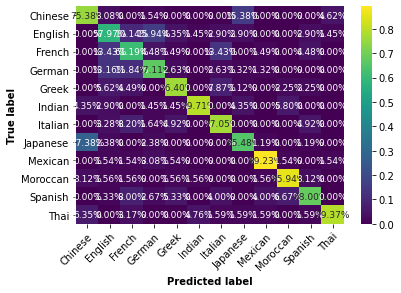

In [331]:
#baseline
model = LogisticRegression(max_iter=1000)
model.fit(X_train, y_train)
predict_logreg_val = model.predict(X_val)
score = model.score(X_val, y_val)
loss = log_loss(y_val, model.predict_proba(X_val))
print("Performance on the val set")
print("Classification accuracy:", score)
print("Log-loss:", loss)
cm_log_reg = confusion_matrix(y_val, predict_logreg_val, normalize='true')
plot_confusion_matrix(cm_log_reg, class_labels=cuisines)

### After group into continents:

Performance on the val set
Classification accuracy: 0.9256198347107438
Log-loss: 0.2156655002286624


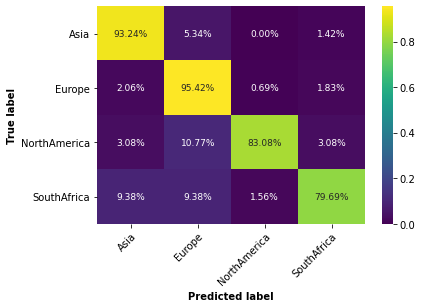

In [332]:
y_train_cont = subgroup(labels=y_train,mode='Continent')
y_val_cont = subgroup(labels=y_val,mode='Continent')
continents = np.unique(y_val_cont)
model_cont = LogisticRegression(max_iter=1000)
model_cont.fit(X_train, np.ravel(y_train_cont))
predict_logreg_val_cont = model_cont.predict(X_val)
score_cont = model_cont.score(X_val, y_val_cont)
loss_cont = log_loss(y_val_cont, model_cont.predict_proba(X_val))
print("Performance on the val set")
print("Classification accuracy:", score_cont)
print("Log-loss:", loss_cont)
cm_log_reg_cont = confusion_matrix(y_val_cont, predict_logreg_val_cont, normalize='true')
plot_confusion_matrix(cm_log_reg_cont, class_labels=continents)

### Iteratively mask through ingredients:

In [333]:
######################################################################
# mask the dataset and train the mdoel using the masked data
# return prediction, accuracy scores and loss
def mask_training (X_train, y_train, X_val, y_val, mask_ing):
    model = LogisticRegression(max_iter=1000)
    X_train_masked = mask_data (X_train , mask_ing)
    X_val_masked = mask_data (X_val,  mask_ing)
    model.fit(X_train_masked,np.ravel(y_train))
    predict_logreg_val = model.predict(X_val_masked)
    score = model.score(X_val_masked, y_val)
    loss = log_loss(y_val, model.predict_proba(X_val_masked))    
    return predict_logreg_val,score,loss

######################################################################
# find the most important ingredient in the given dataset by iteratively masking the ingredients
# return the scores, losses and predictions after masking each ingredient
def findMostImportantIng (X_train, y_train, X_val, y_val):
    scores= {}
    losses = {}
    preds = {} 
    for ing in ing_headline:
        pred,score,loss = mask_training(X_train,y_train,X_val,y_val,mask_ing=ing)
        scores[ing]=score
        preds[ing]=pred
        losses[ing]=loss
    return scores,losses,preds
######################################################################
# visualise the result in confusion matrix
def visualise_topIng (groudTruth,preds,scores,losses,number=10):
    class_labels = np.unique(groudTruth)
    
    print ("original plot without masking with acc {}".format(scores['ORIGIN']))
    pred = preds['ORIGIN']
    cm_log_reg = confusion_matrix(groudTruth, pred, normalize='true')
    plot_confusion_matrix(cm_log_reg, class_labels=class_labels)     
    
    keys = getKeys(losses,'max',number)
    for key in keys:
        print ("ingredient {} with acc {}".format(key,scores[key]))
        pred = preds[key]
        cm_log_reg = confusion_matrix(groudTruth, pred, normalize='true')
        plot_confusion_matrix(cm_log_reg, class_labels=class_labels)
    return keys
######################################################################
# find the most important ingredient in continent or subgroup of countries
# return scores, losses and predictions after masking each ingredient
def subgroupAndFind (X_train=None,y_train=None,X_val=None,y_val=None,mode=None,target_cusine=None):
    if (mode != 'Continent' and mode != 'Country'):
        print ('mode should be Continent or Country')
        raise
    if (mode == 'Continent'):
        y_train_cont = subgroup(labels=y_train,mode=mode)
        y_val_cont = subgroup(labels=y_val,mode=mode)
        model = LogisticRegression(max_iter=1000)
        model.fit(X_train, np.ravel(y_train_cont))
        predict_logreg_val_cont = model.predict(X_val)
        score_cont = model.score(X_val, y_val_cont)
        loss_cont = log_loss(y_val_cont, model.predict_proba(X_val))
        scores,losses,preds = findMostImportantIng (X_train,y_train_cont,X_val,y_val_cont)
        scores ['ORIGIN'] = score_cont
        losses ['ORIGIN'] = loss_cont
        preds ['ORIGIN'] = predict_logreg_val_cont
        return scores,losses,preds,y_train_cont,y_val_cont
    if (mode == 'Country'):
        X_train_new, y_train_new = subgroup(X_train,y_train,mode,target_cusine)
        X_val_new, y_val_new = subgroup(X_train,y_train,mode,target_cusine)
        model = LogisticRegression(max_iter=1000)
        model.fit(X_train_new, np.ravel(y_train_new))
        predict_logreg_val = model.predict(X_val_new)
        score = model.score(X_val_new, y_val_new)
        loss = log_loss(y_val_new, model.predict_proba(X_val_new))
        scores,losses,preds = findMostImportantIng (X_train_new,y_train_new,X_val_new,y_val_new)
        scores ['ORIGIN'] = score
        losses ['ORIGIN'] = loss
        preds ['ORIGIN'] = predict_logreg_val
        return scores,losses,preds,y_train_new,y_val_new

In [334]:
scores,losses,preds,_,y_val_new = subgroupAndFind (X_train,y_train,X_val,y_val,mode='Continent')


original plot without masking with acc 0.9256198347107438


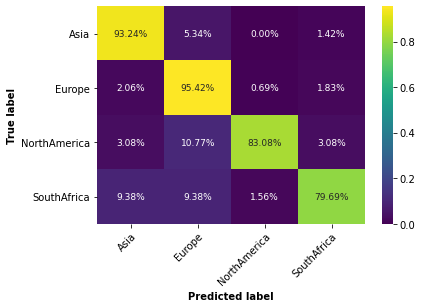

ingredient curry powder with acc 0.9161747343565525


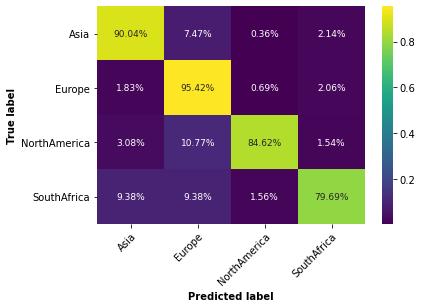

ingredient tortilla with acc 0.9232585596221959


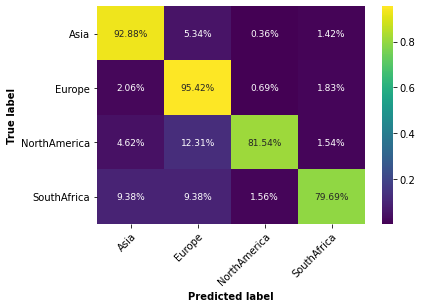

ingredient olive oil with acc 0.9244391971664699


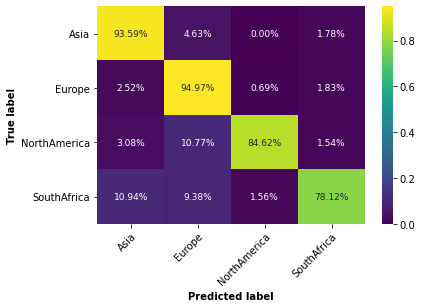

ingredient soy sauce with acc 0.9256198347107438


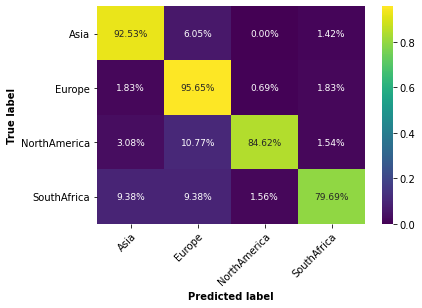

ingredient ginger with acc 0.9232585596221959


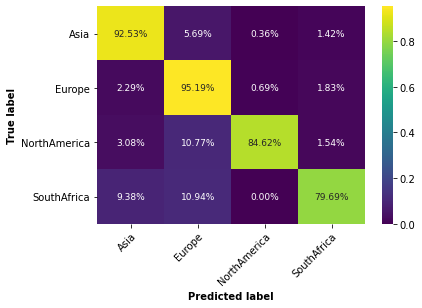

ingredient cumin with acc 0.9268004722550177


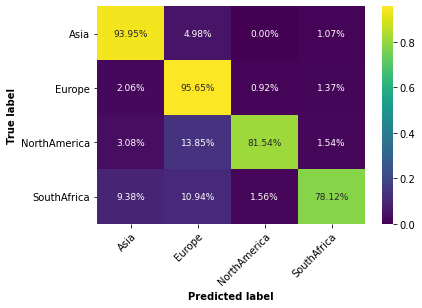

ingredient coconut milk or cream with acc 0.9232585596221959


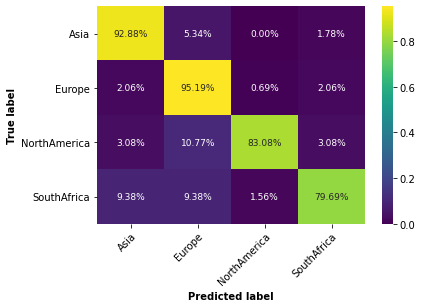

ingredient ras el hanout with acc 0.9232585596221959


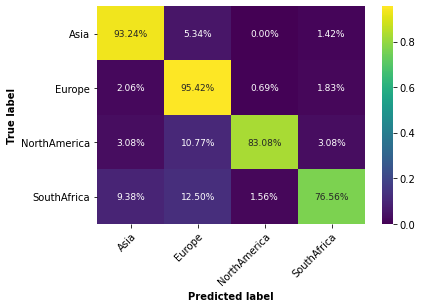

ingredient harissa with acc 0.922077922077922


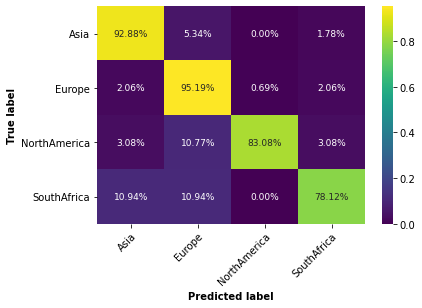

ingredient oregano with acc 0.9268004722550177


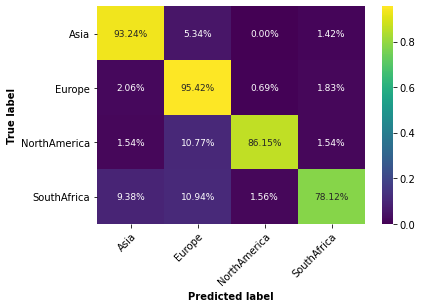

In [335]:
topIng = visualise_topIng(y_val_new,preds,scores,losses)

# Find the most important ingredient between Chinese and Japanese

In [336]:
scores,losses,preds,_,y_val_new = subgroupAndFind (X_train,y_train,X_val,y_val,mode='Country',target_cusine =['Chinese','Japanese'])


original plot without masking with acc 0.9406175771971497


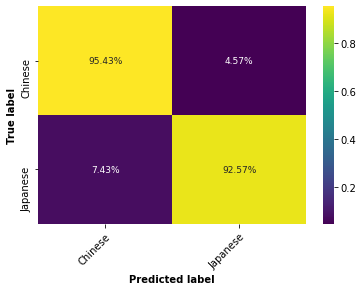

ingredient rice wine with acc 0.9358669833729216


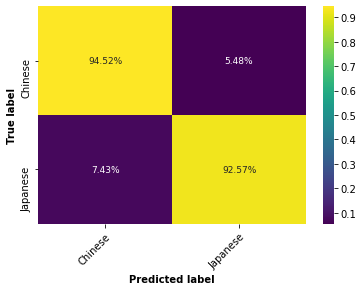

ingredient tofu with acc 0.9334916864608076


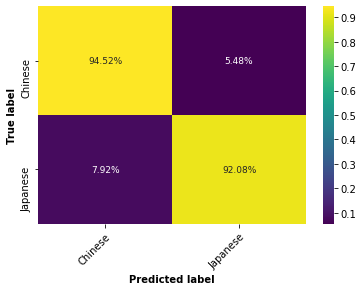

ingredient cornstarch with acc 0.9453681710213777


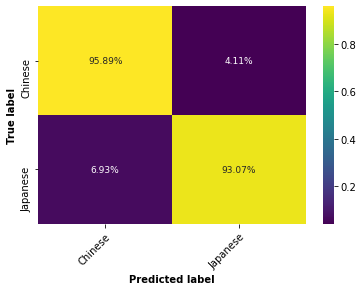

ingredient sesame oil with acc 0.9406175771971497


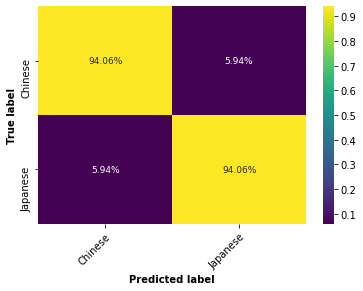

ingredient sherry with acc 0.9453681710213777


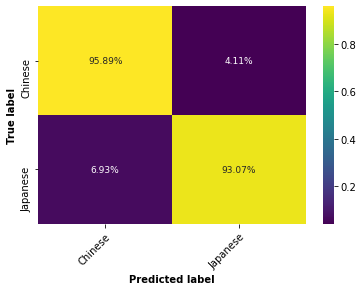

ingredient hoisin sauce with acc 0.9453681710213777


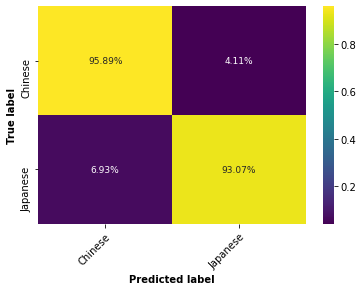

ingredient ginger with acc 0.9477434679334917


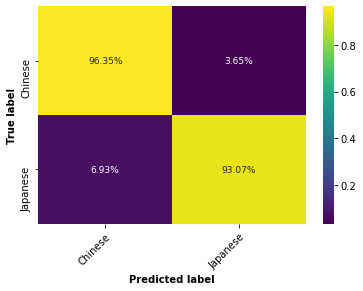

ingredient tuna with acc 0.9358669833729216


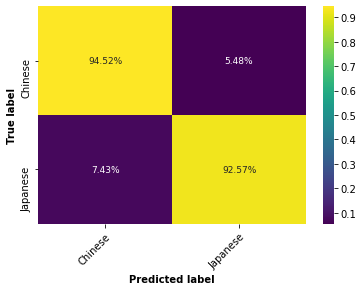

ingredient chicken with acc 0.9334916864608076


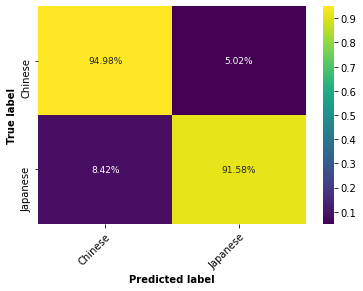

ingredient sausage with acc 0.9382422802850356


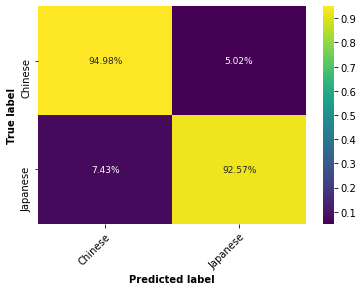

['rice wine', 'tofu', 'cornstarch', 'sesame oil', 'sherry', 'hoisin sauce', 'ginger', 'tuna', 'chicken', 'sausage']
ingredient is rice wine
frequency the ingredient rice wine been in chinese cuisine is 7
frequency the ingredient rice wine been in japanese cuisine is 31


ingredient is tofu
frequency the ingredient tofu been in chinese cuisine is 1
frequency the ingredient tofu been in japanese cuisine is 7


ingredient is cornstarch
frequency the ingredient cornstarch been in chinese cuisine is 30
frequency the ingredient cornstarch been in japanese cuisine is 16


ingredient is sesame oil
frequency the ingredient sesame oil been in chinese cuisine is 20
frequency the ingredient sesame oil been in japanese cuisine is 18


ingredient is sherry
frequency the ingredient sherry been in chinese cuisine is 15
frequency the ingredient sherry been in japanese cuisine is 4


ingredient is hoisin sauce
frequency the ingredient hoisin sauce been in chinese cuisine is 6
frequency the ingredient ho

In [337]:
topIng = visualise_topIng(y_val_new,preds,scores,losses)
print (topIng)
for ing in topIng:
    print ("ingredient is {}".format(ing))
    idx = np.array(np.where(X_val[ing]==1)).squeeze()
    chinese_c = 0
    japanese_c = 0
    for i in idx:
        if (y_val.iloc[i].label == 'Chinese'):
            chinese_c +=1
        if (y_val.iloc[i].label == 'Japanese'):
            japanese_c +=1
    print ('frequency the ingredient {} been in chinese cuisine is {}'.format(ing,chinese_c))
    print ('frequency the ingredient {} been in japanese cuisine is {}'.format(ing,japanese_c))
    print ("\n")

# Find the most important ingredient between Chinese and Indian

In [338]:
scores,losses,preds,_,y_val_new = subgroupAndFind (X_train,y_train,X_val,y_val,mode='Country',target_cusine =['Chinese','Indian'])


original plot without masking with acc 0.9952941176470588


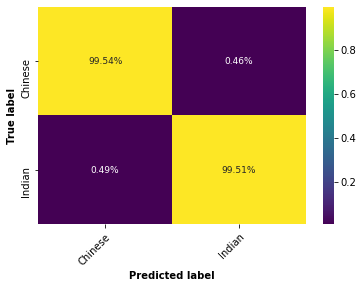

ingredient soy sauce with acc 0.9976470588235294


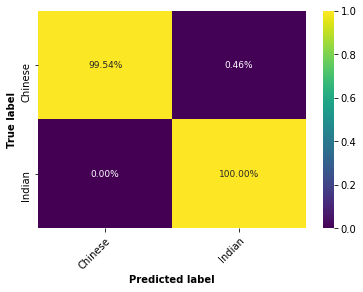

ingredient masala with acc 0.9929411764705882


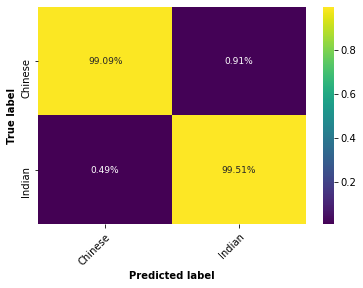

ingredient yogurt with acc 0.9952941176470588


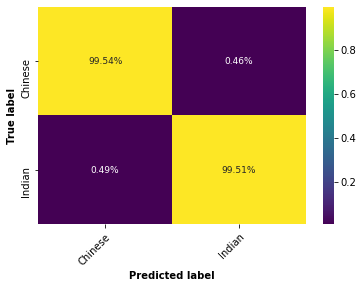

ingredient chicken stock with acc 0.9952941176470588


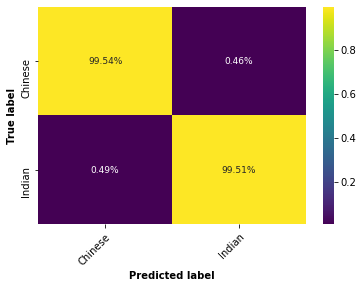

ingredient curry powder with acc 0.9952941176470588


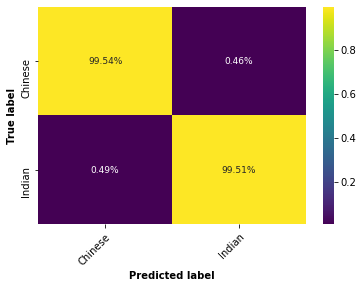

ingredient onion with acc 0.9952941176470588


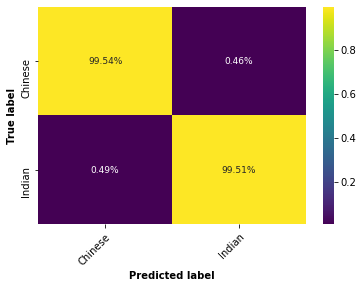

ingredient cornstarch with acc 0.9929411764705882


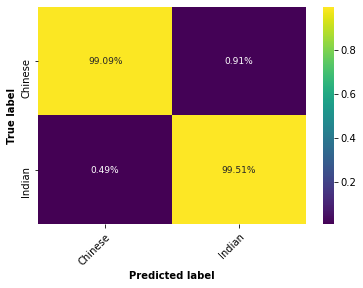

ingredient tomato puree with acc 0.9952941176470588


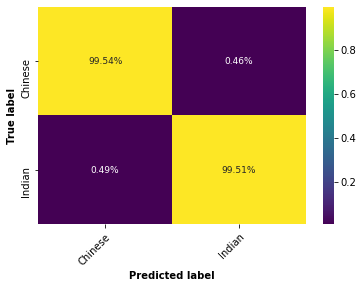

ingredient sesame oil with acc 0.9952941176470588


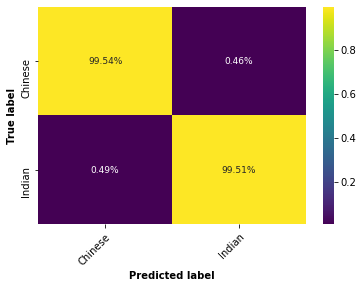

ingredient coconut milk or cream with acc 0.9952941176470588


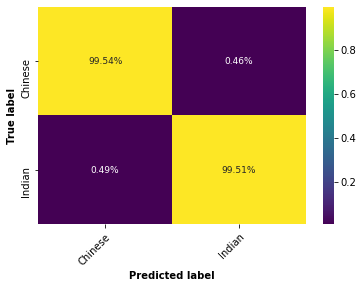

['soy sauce', 'masala', 'yogurt', 'chicken stock', 'curry powder', 'onion', 'cornstarch', 'tomato puree', 'sesame oil', 'coconut milk or cream']
ingredient is soy sauce
frequency the ingredient soy sauce been in chinese cuisine is 58
frequency the ingredient soy sauce been in japanese cuisine is 3


ingredient is masala
frequency the ingredient masala been in chinese cuisine is 0
frequency the ingredient masala been in japanese cuisine is 18


ingredient is yogurt
frequency the ingredient yogurt been in chinese cuisine is 0
frequency the ingredient yogurt been in japanese cuisine is 9


ingredient is chicken stock
frequency the ingredient chicken stock been in chinese cuisine is 1
frequency the ingredient chicken stock been in japanese cuisine is 5


ingredient is curry powder
frequency the ingredient curry powder been in chinese cuisine is 1
frequency the ingredient curry powder been in japanese cuisine is 22


ingredient is onion
frequency the ingredient onion been in chinese cuisine

In [339]:
topIng = visualise_topIng(y_val_new,preds,scores,losses)
print (topIng)
for ing in topIng:
    print ("ingredient is {}".format(ing))
    idx = np.array(np.where(X_val[ing]==1)).squeeze()
    chinese_c = 0
    japanese_c = 0
    for i in idx:
        if (y_val.iloc[i].label == 'Chinese'):
            chinese_c +=1
        if (y_val.iloc[i].label == 'Indian'):
            japanese_c +=1
    print ('frequency the ingredient {} been in chinese cuisine is {}'.format(ing,chinese_c))
    print ('frequency the ingredient {} been in japanese cuisine is {}'.format(ing,japanese_c))
    print ("\n")

# Find the most important ingredient between Chinese and Italian

In [340]:
scores,losses,preds,_,y_val_new = subgroupAndFind (X_train,y_train,X_val,y_val,mode='Country',target_cusine =['Chinese','Italian'])


original plot without masking with acc 1.0


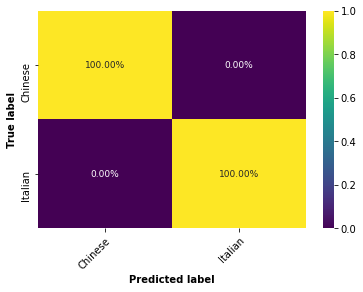

ingredient soy sauce with acc 1.0


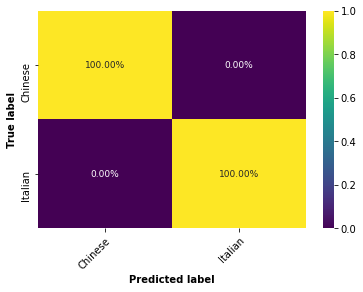

ingredient ginger with acc 1.0


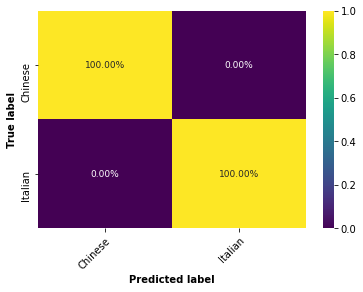

ingredient olive oil with acc 1.0


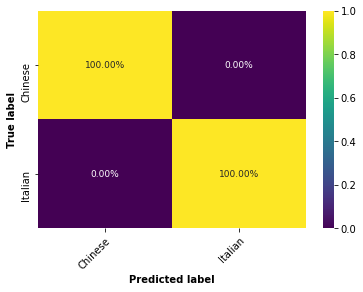

ingredient green onion with acc 1.0


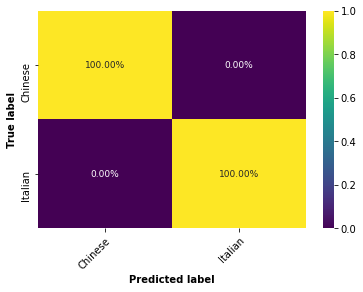

ingredient parmesan cheese with acc 1.0


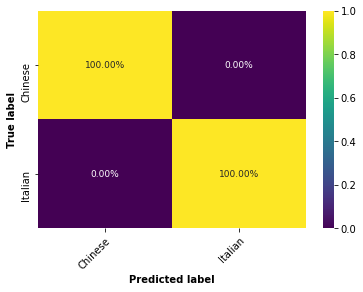

ingredient sugar with acc 1.0


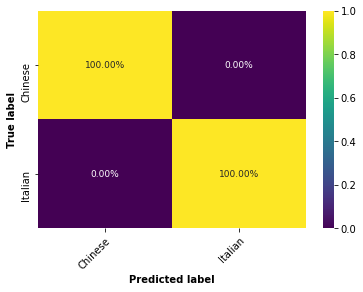

ingredient pasta with acc 1.0


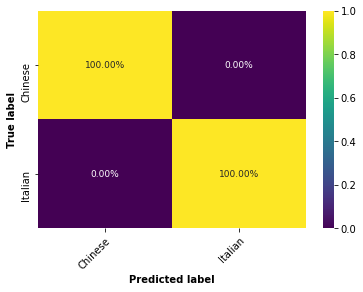

ingredient sesame oil with acc 1.0


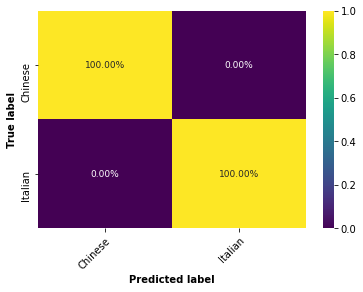

ingredient mozzarella with acc 1.0


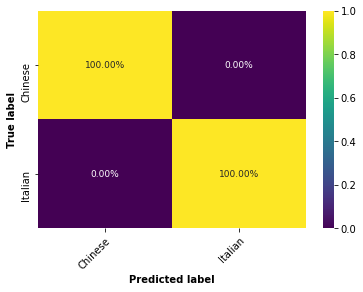

ingredient parsley with acc 1.0


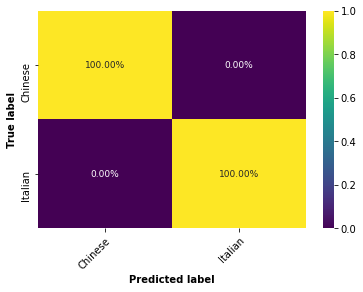

['soy sauce', 'ginger', 'olive oil', 'green onion', 'parmesan cheese', 'sugar', 'pasta', 'sesame oil', 'mozzarella', 'parsley']
ingredient is soy sauce
frequency the ingredient soy sauce been in chinese cuisine is 58
frequency the ingredient soy sauce been in japanese cuisine is 3


ingredient is ginger
frequency the ingredient ginger been in chinese cuisine is 37
frequency the ingredient ginger been in japanese cuisine is 38


ingredient is olive oil
frequency the ingredient olive oil been in chinese cuisine is 4
frequency the ingredient olive oil been in japanese cuisine is 8


ingredient is green onion
frequency the ingredient green onion been in chinese cuisine is 29
frequency the ingredient green onion been in japanese cuisine is 3


ingredient is parmesan cheese
frequency the ingredient parmesan cheese been in chinese cuisine is 0
frequency the ingredient parmesan cheese been in japanese cuisine is 0


ingredient is sugar
frequency the ingredient sugar been in chinese cuisine is 

In [341]:
topIng = visualise_topIng(y_val_new,preds,scores,losses)
print (topIng)
for ing in topIng:
    print ("ingredient is {}".format(ing))
    idx = np.array(np.where(X_val[ing]==1)).squeeze()
    chinese_c = 0
    japanese_c = 0
    for i in idx:
        if (y_val.iloc[i].label == 'Chinese'):
            chinese_c +=1
        if (y_val.iloc[i].label == 'Indian'):
            japanese_c +=1
    print ('frequency the ingredient {} been in chinese cuisine is {}'.format(ing,chinese_c))
    print ('frequency the ingredient {} been in japanese cuisine is {}'.format(ing,japanese_c))
    print ("\n")